<a href="https://colab.research.google.com/github/andBabaev/ds_school_2020/blob/master/task%205/keras_leaf_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp '/content/drive/My Drive/leaf_dataset.zip' './'
!unzip leaf_dataset.zip

In [0]:
!pip install --upgrade tqdm  --progress-bar off

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from os import listdir, path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.random import set_seed
from tqdm.keras import TqdmCallback
from keras.initializers import glorot_uniform 
from sklearn.metrics import classification_report
from keras.models import Model

In [4]:
labels = pd.read_csv('leaf_dataset/train.csv')
print(labels.shape)
labels.head()

(1821, 5)


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


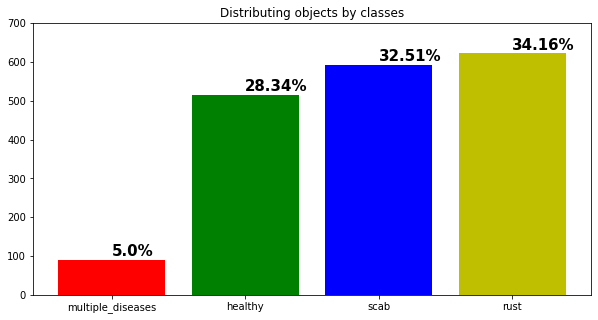

In [100]:
count_labels = labels.iloc[:, 1:].sum().sort_values()
plt.figure(figsize=(10,5))
plt.title('Distributing objects by classes')
plt.ylim((0,700))
plt.bar(count_labels.index, count_labels, color=['r', 'g', 'b', 'y'])
for i, v in count_labels.items():
    plt.text(i, v+10, str(np.round(v/np.sum(count_labels)*100, 2))+'%', color='black', fontweight='bold', fontsize=15)

All classes are evenly distributed except class "multiple_diseases". It is a problem. 

Let us visualize several objects of each class

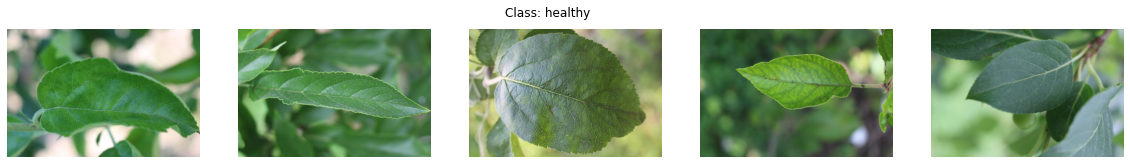

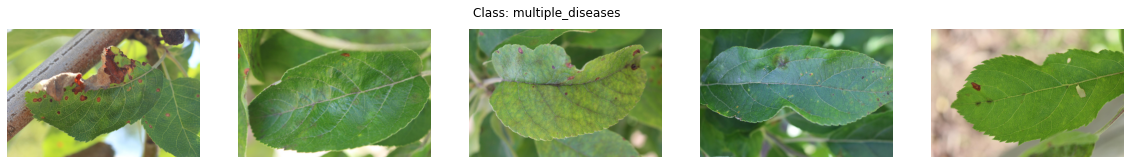

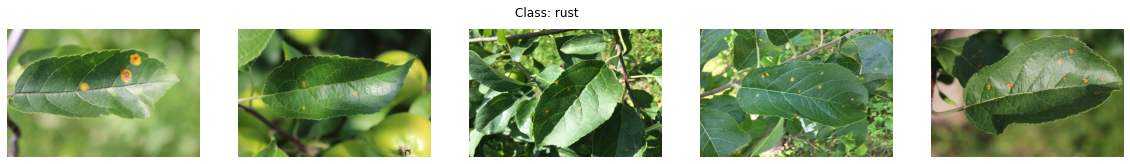

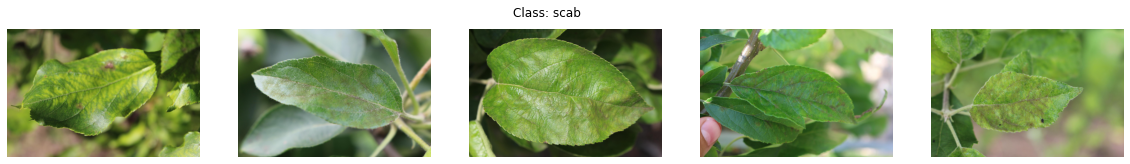

In [7]:
image_per_class = 5
for class_ in labels.columns[1:]:
    temp_df = labels[labels[class_]==1][:image_per_class]
    plt.figure(figsize=(20,2.5))
    plt.suptitle('Class: '+class_)
    for i in range(image_per_class):
        plt.subplot(1, image_per_class, i+1)
        plt.axis('off')
        plt.imshow(Image.open('leaf_dataset/images/%s.jpg' % temp_df.iloc[i,0]));

# Load dataset

Compare the speed of preparing a color image

In [0]:
%%timeit
img = cv2.imread('leaf_dataset/images/Train_0.jpg')

10 loops, best of 3: 28.6 ms per loop


In [0]:
%%timeit
img = np.array(Image.open('leaf_dataset/images/Train_0.jpg'))

10 loops, best of 3: 36.7 ms per loop


and grayscale image

In [0]:
%%timeit
img_color = cv2.imread('leaf_dataset/images/Train_0.jpg')
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

10 loops, best of 3: 30.5 ms per loop


In [0]:
%%timeit
img_color = Image.open('leaf_dataset/images/Train_0.jpg')
img_gray = np.array(img_color.convert('L'))
img_color = np.array(img_color)

10 loops, best of 3: 45.2 ms per loop


In [8]:
image_filenames = labels['image_id']
size = 128
X_color = np.zeros((len(image_filenames), size, size, 3), dtype='float32')
X_gray = np.zeros((len(image_filenames), size, size), dtype='float32')
for i, filename in enumerate(tqdm(image_filenames)):
    path_to_image = 'leaf_dataset/images/%s.jpg' % filename
    img_color = cv2.imread(path_to_image)
    img_color = cv2.resize(img_color, (size, size), interpolation=cv2.INTER_AREA)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    X_color[i] = img_color
    X_gray[i] = img_gray


In [0]:
X_color = X_color / 255.0
X_gray = X_gray / 255.0
X_gray = X_gray[:,:,:, np.newaxis]

In [0]:
classes = labels.columns[1:]
y = labels[classes]

# Without dropout

## CNN for color images

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X_color, y, test_size=0.3, random_state=42)
print('Size of train data:', X_train.shape)
print('Size of test data:', X_test.shape)

Size of train data: (1274, 128, 128, 3)
Size of test data: (547, 128, 128, 3)


In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [212]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    epochs=30,
                    verbose=0, callbacks=[TqdmCallback(verbose=0)])

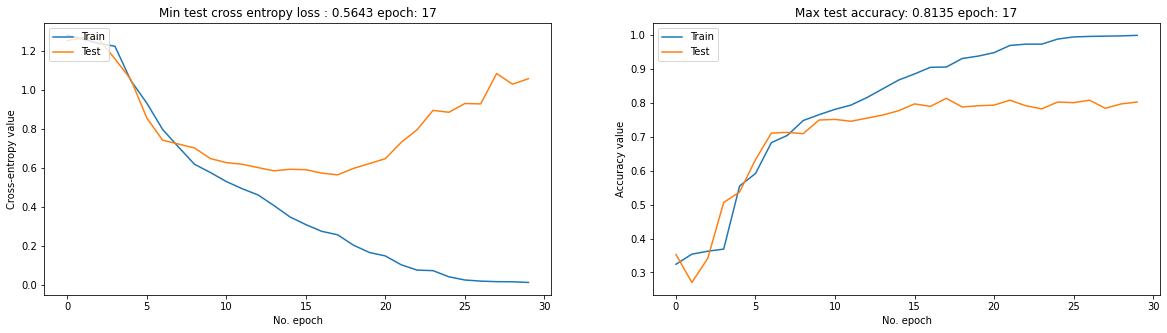

In [213]:
def history_vis(history):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((history.history['val_loss'])), np.argmin(history.history['val_loss'])))
    plt.ylabel('Cross-entropy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])))
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
history_vis(history)

## CNN for grayscale images

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_gray, y, test_size=0.3, random_state=42)
print('Size of train data:', X_train.shape)
print('Size of test data:', X_test.shape)

Size of train data: (1274, 128, 128, 1)
Size of test data: (547, 128, 128, 1)


In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

input_shape = X_train[0].shape[0], X_train[0].shape[0], 1

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [216]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    epochs=30,
                    verbose=0, callbacks=[TqdmCallback(verbose=0)])

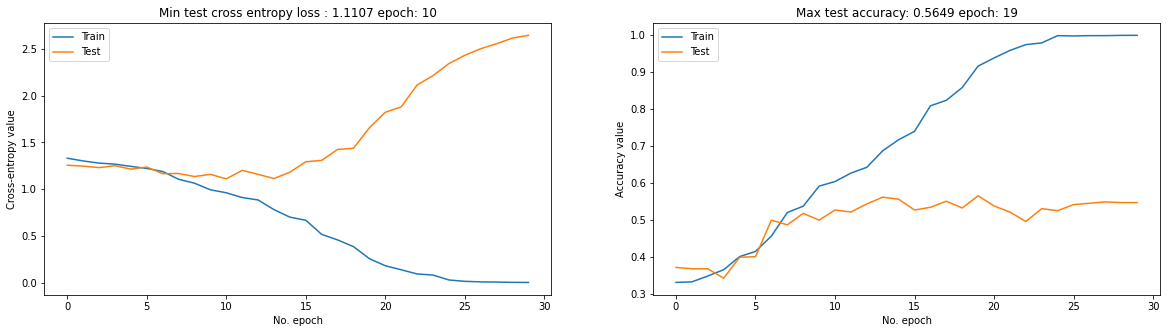

In [217]:
history_vis(history)

Probably in this task color is of great importance

# Add dropout

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X_color, y, test_size=0.3, random_state=42)
print('Size of train data:', X_train.shape)
print('Size of test data:', X_test.shape)

Size of train data: (1274, 128, 128, 3)
Size of test data: (547, 128, 128, 3)


In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.33))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.33))
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.33))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [220]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    epochs=30,
                    verbose=0, callbacks=[TqdmCallback(verbose=0)])

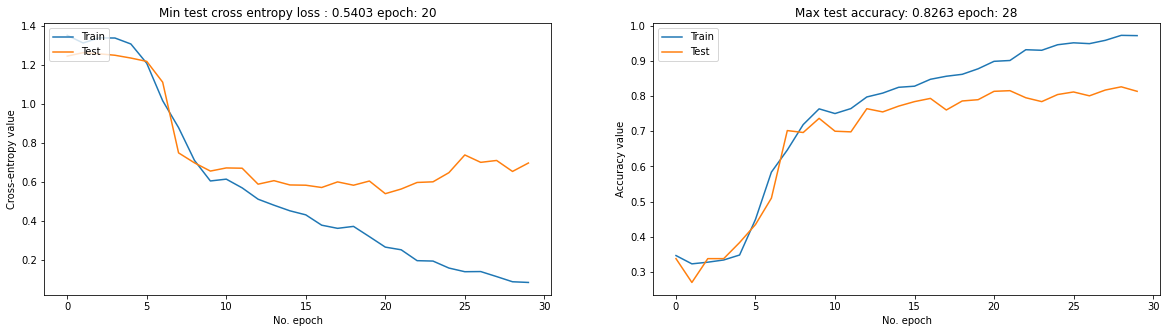

In [221]:
history_vis(history)

Dropout allowed to reduce overfitting and increase accuracy. Let us analyze the accuracy of the model at different dropout values

Current dropout: 0.0
Current dropout: 0.1
Current dropout: 0.2
Current dropout: 0.30000000000000004
Current dropout: 0.4
Current dropout: 0.5
Current dropout: 0.6000000000000001
Current dropout: 0.7000000000000001
Current dropout: 0.8
Current dropout: 0.9


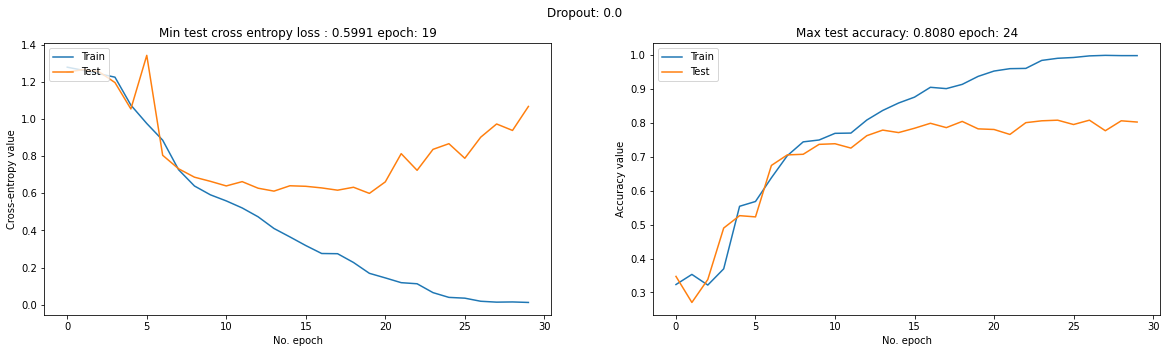

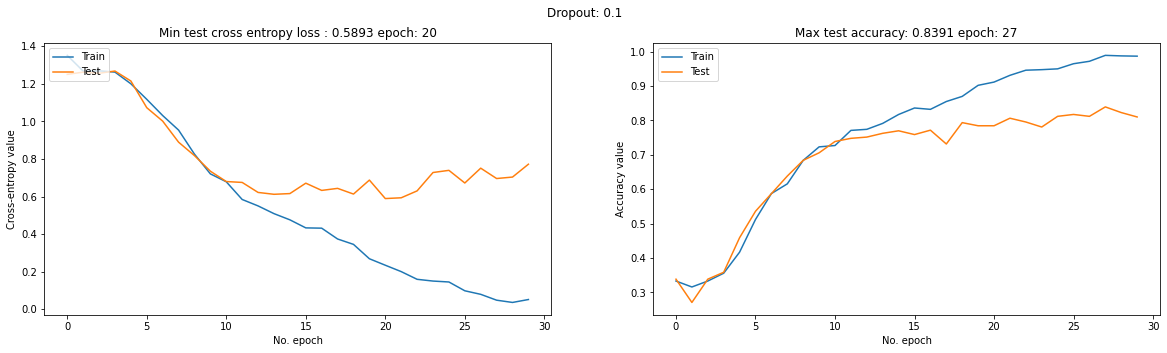

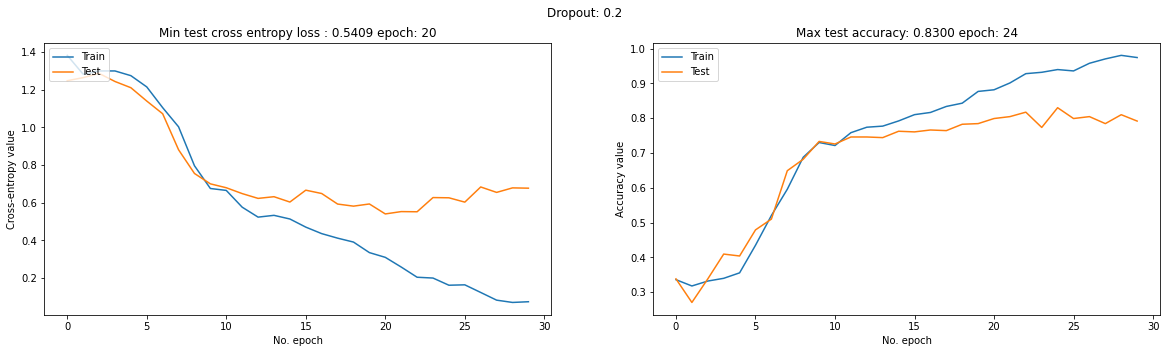

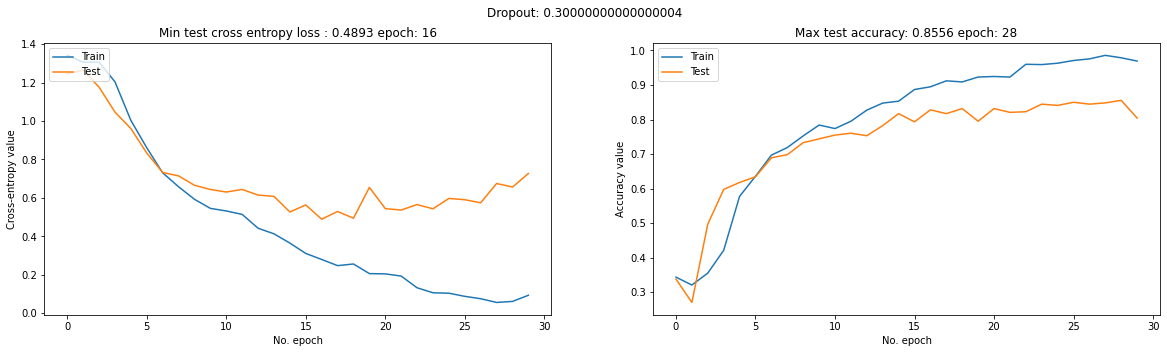

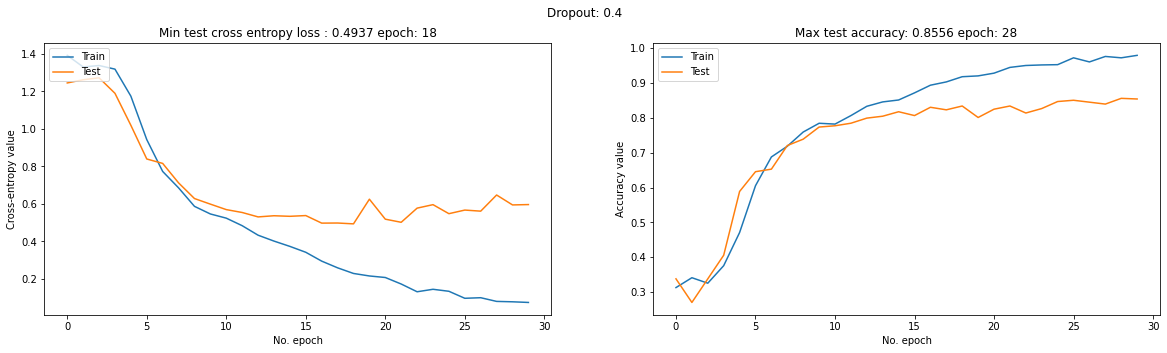

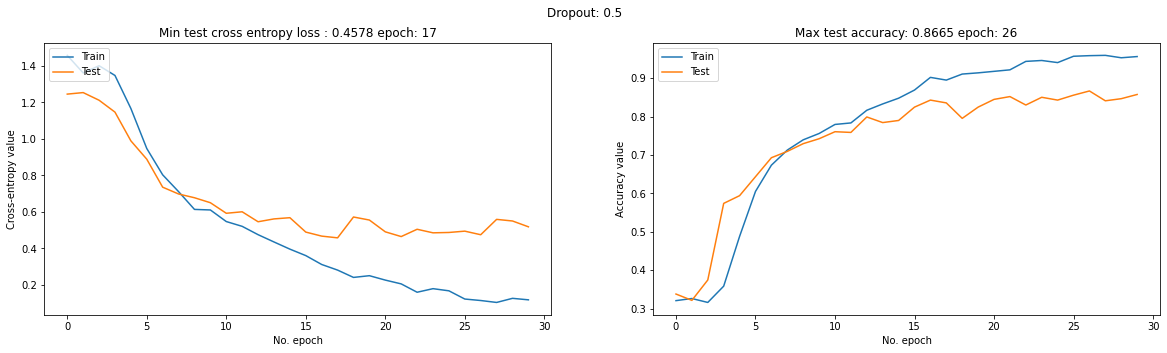

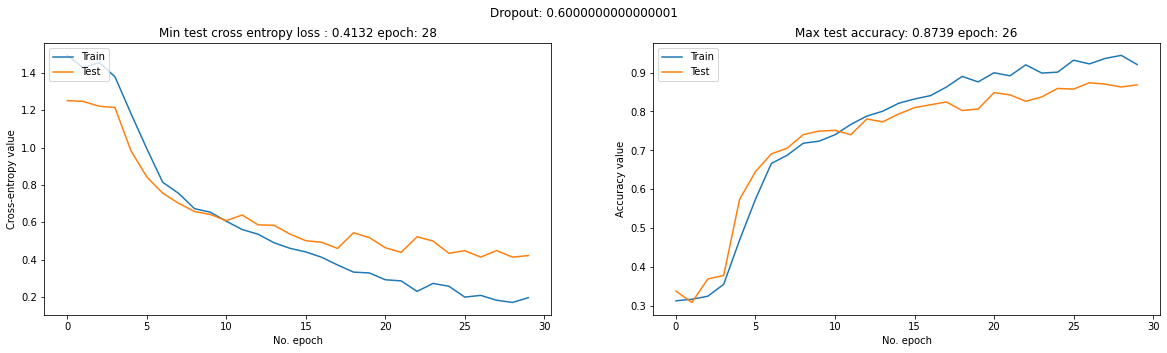

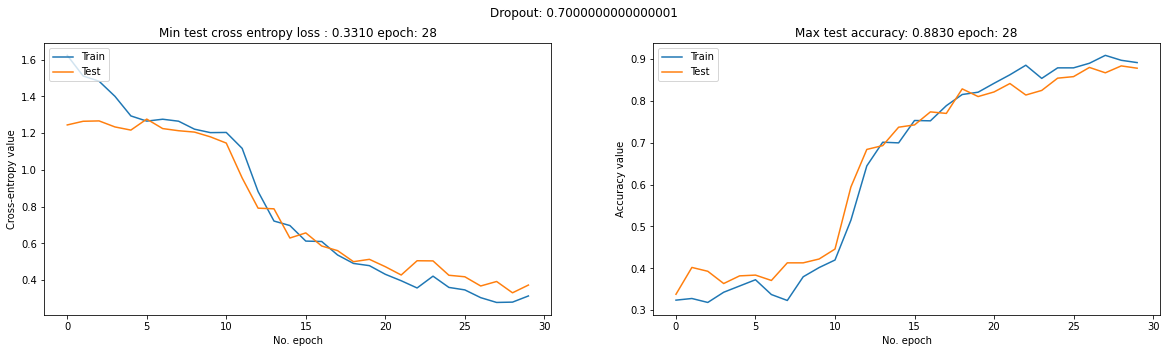

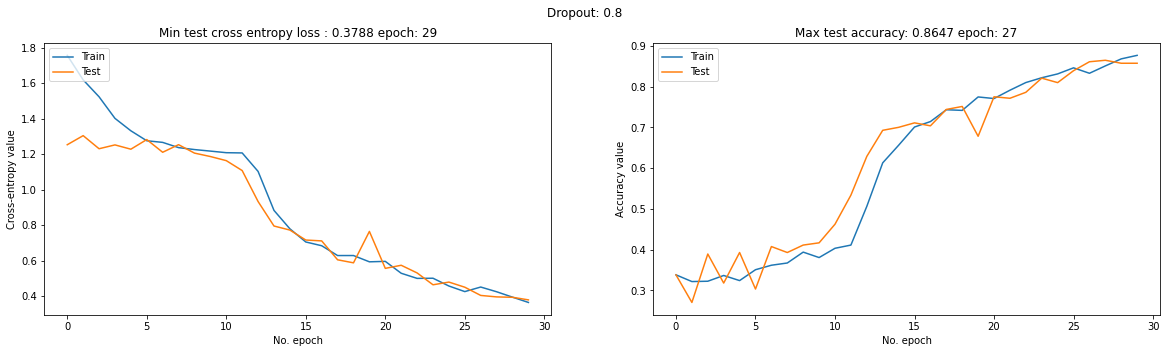

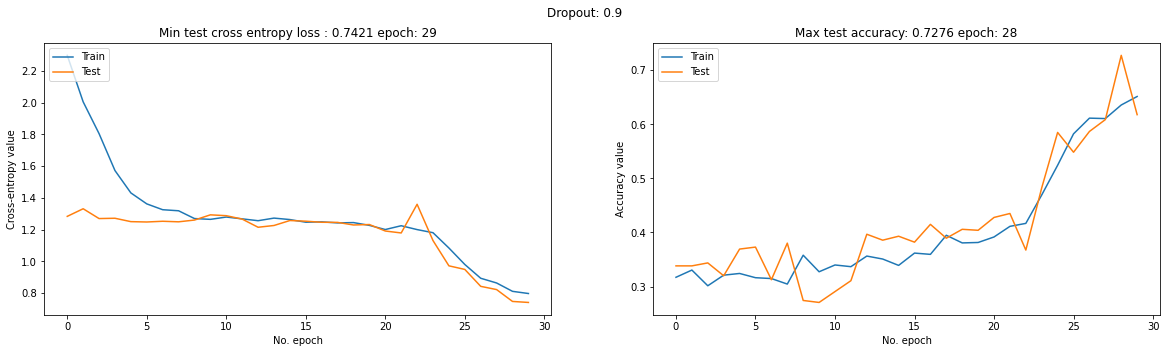

In [0]:
 dropout_arr = np.arange(0, 1, 0.1)
 for drop_coef in dropout_arr:
    print('Current dropout:', drop_coef)
    seed = 42
    np.random.seed(seed)
    set_seed(seed)

    input_shape = X_train[0].shape

    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_coef))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_coef))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='sigmoid'))
    model.add(Dropout(drop_coef))
    model.add(Dense(len(classes), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=64,
                        epochs=30,
                        verbose=0)
    
    plt.figure(figsize=(20,5))
    plt.suptitle('Dropout: %s' % drop_coef)

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Min test cross entropy loss : %.4f epoch: %s' % (np.min((history.history['val_loss'])), np.argmin(history.history['val_loss'])))
    plt.ylabel('Cross-entropy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Max test accuracy: %.4f epoch: %s' % (np.max((history.history['val_accuracy'])), np.argmax(history.history['val_accuracy'])))
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")

With small dropout values (dropout < 0.5), there is the effect of overfitting. With the growth of the dropout, overfitting decreases, but with a large dropout (> 0.7) the model becomes underfitting. A neural network has better accuracy at a dropout = 0.7

In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)
drop_coef = 0.7

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_coef))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_coef))

model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(drop_coef))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30,
                    verbose=0)

In [19]:
pred = model.predict_classes(X_test)
print(classification_report(y_test.values.argmax(axis=1), pred, target_names=classes))

                   precision    recall  f1-score   support

          healthy       0.86      0.91      0.88       148
multiple_diseases       0.25      0.07      0.11        29
             rust       0.92      0.98      0.95       185
             scab       0.86      0.86      0.86       185

         accuracy                           0.87       547
        macro avg       0.72      0.71      0.70       547
     weighted avg       0.85      0.87      0.86       547



The model is of poor quality for class 'multiple_diseases', because it contains very few objects. Set the weights for classes

In [0]:
w = class_weight.compute_class_weight('balanced',  np.unique(y.values.argmax(axis=1)), y.values.argmax(axis=1))

In [0]:
seed = 42
np.random.seed(seed)
set_seed(seed)

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30,
                    verbose=0,
                    class_weight=w)

In [22]:
pred = model.predict_classes(X_test)
print(classification_report(y_test.values.argmax(axis=1), pred, target_names=classes))

                   precision    recall  f1-score   support

          healthy       0.83      0.97      0.89       148
multiple_diseases       0.50      0.21      0.29        29
             rust       0.94      0.98      0.96       185
             scab       0.93      0.85      0.89       185

         accuracy                           0.89       547
        macro avg       0.80      0.75      0.76       547
     weighted avg       0.88      0.89      0.88       547



Balanced weights improved quality for class 'multiple_diseases'

# Save model

In [39]:
# serialize model to JSON
model_json = model.to_json()
with open("drive/My Drive/model_89.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("drive/My Drive/model_89.h5")
print("Saved model to disk")

Saved model to disk


# Test image

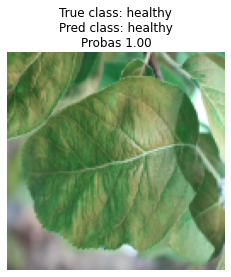

In [91]:
ind = 1
test_image = X_test[ind].copy()
probas = model.predict_proba(np.expand_dims(test_image, axis=0))
plt.imshow(test_image)
plt.title('True class: %s\nPred class: %s\nProbas %.2f' % (classes[y_test.values[ind].argmax()], classes[probas[0].argmax()], probas[0].max()))
plt.axis('off');

# Vizualization feature maps

In [92]:
for i, layer in enumerate(model.layers):
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_13 (None, 126, 126, 32)
2 conv2d_14 (None, 61, 61, 64)
4 conv2d_15 (None, 28, 28, 128)
7 conv2d_16 (None, 12, 12, 128)


In [0]:
ixs = [0, 2, 4, 7]
outputs = [model.layers[i].output for i in ixs]
model_FMaps = Model(inputs=model.inputs, outputs=outputs)

In [0]:
feature_maps = model_FMaps.predict(np.expand_dims(test_image, axis=0))

In [0]:
def feature_map_vis(layer_id, n_rows=4, n_col=8, figsize=(10,5)):
    layer = model.layers[ixs[layer_id]]
    plt.figure(figsize=figsize)
    plt.suptitle('Feature maps for %s %s' % (layer.name, layer.output.shape))
    ix = 1
    for _ in range(n_rows):
        for _ in range(n_col):
            # specify subplot and turn of axis
            plt.subplot(n_rows, n_col, ix)
            plt.axis('off')
            # plot filter channel in grayscale
            plt.imshow(feature_maps[layer_id][0, :, :, ix-1])
            ix += 1
    # show the figure
    plt.show()

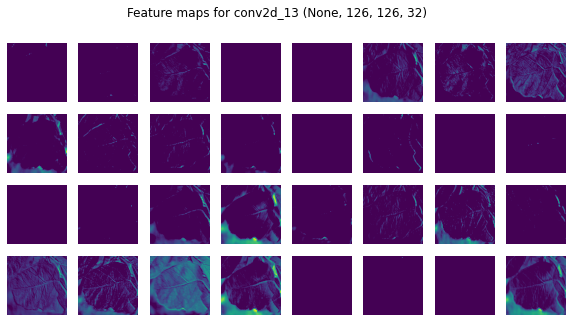

In [96]:
feature_map_vis(0)

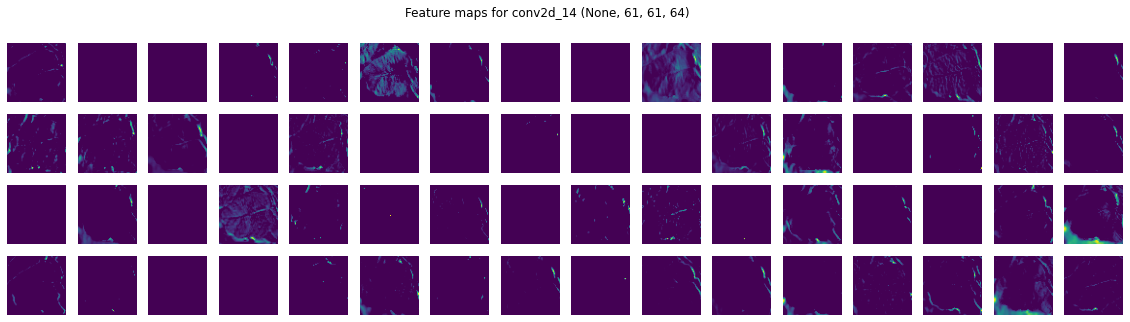

In [97]:
feature_map_vis(1, 4, 16, (20,5))

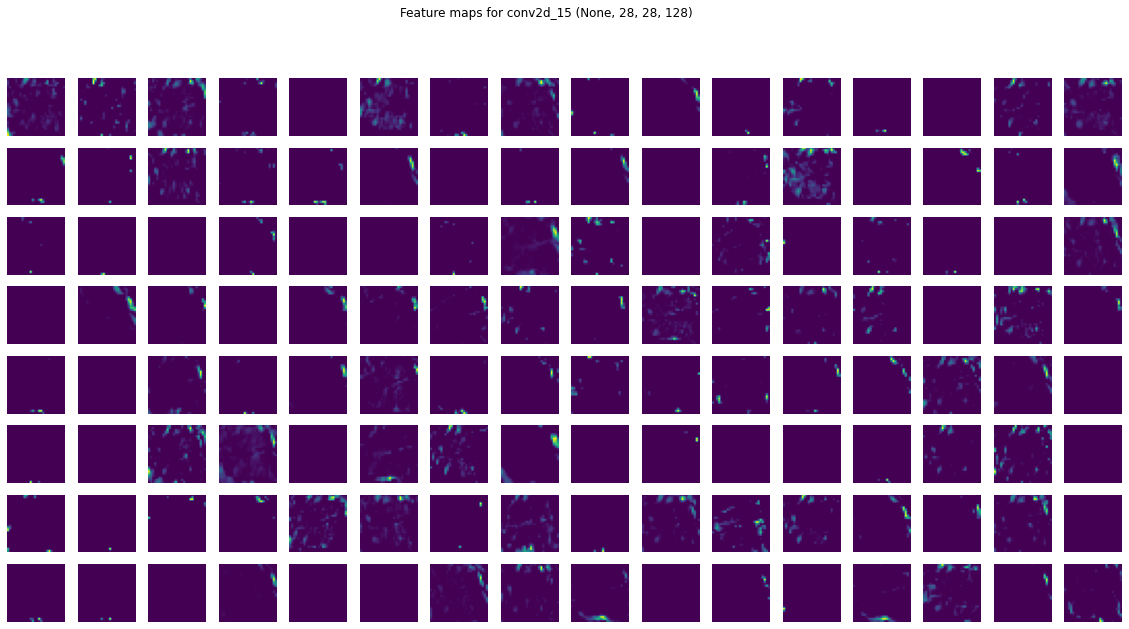

In [98]:
feature_map_vis(2, 8, 16, (20,10))

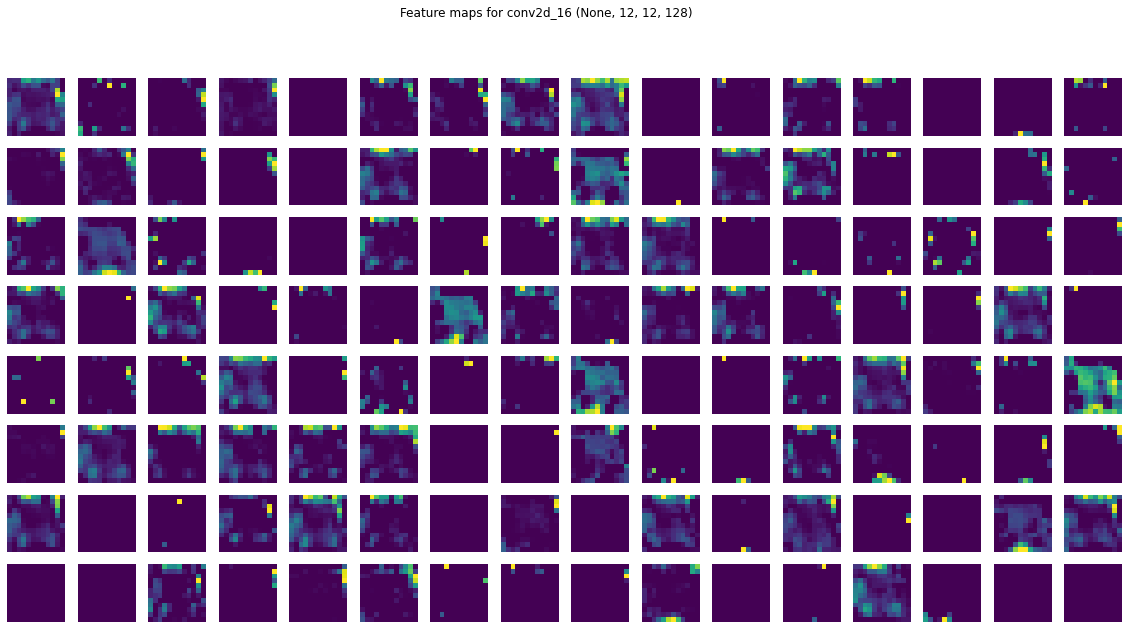

In [99]:
feature_map_vis(3, 8, 16, (20,10))

# Data augmentation for class "multiple_diseases"

Why not

In [0]:
image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3)

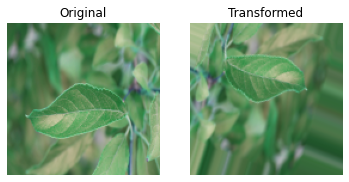

In [199]:
plt.subplot(1,2,1)
plt.title('Original')
plt.axis('off')
plt.imshow(X_train[0])
plt.subplot(1,2,2)
plt.title('Transformed')
plt.axis('off')
plt.imshow(image_gen.random_transform(X_train[0]));

In [200]:
y_train.sum()

healthy              368
multiple_diseases     62
rust                 437
scab                 407
dtype: int64

Add 368-62=306 objects of class 'multiple_diseases'  to the training dataset.

In [0]:
num_objects = 368-62
new_images = np.zeros((num_objects, 128, 128, 3))
new_labels = np.array([[0,1,0,0]]*num_objects)

In [202]:
multiple_diseases_train = y_train.values[:, 1]
multiple_diseases_images = X_train[multiple_diseases_train == 1]
multiple_diseases_images.shape

(62, 128, 128, 3)

In [203]:
for i in tqdm(range(num_objects)):
    rand_index = np.random.choice(multiple_diseases_images.shape[0], 1)[0]
    new_images[i] = image_gen.random_transform(multiple_diseases_images[rand_index])

In [0]:
X_train_aug = np.vstack((X_train, new_images))
y_train_aug = np.vstack((y_train.values, new_labels))

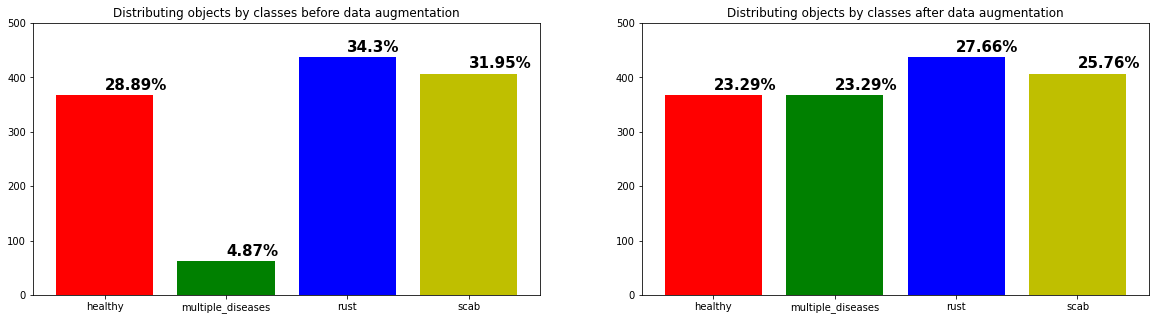

In [191]:
plt.figure(figsize=(20,5))
for i, (t, labels_arr) in enumerate(zip(['Distributing objects by classes before data augmentation', 
                                         'Distributing objects by classes after data augmentation'], 
                                        [y_train, y_train_aug]), 1):
    plt.subplot(1,2,i)
    count_labels = labels_arr.sum(axis=0)
    plt.title(t)
    plt.ylim((0,500))
    plt.bar(classes, count_labels, color=['r', 'g', 'b', 'y'])
    for i, v in zip(classes, count_labels):
        plt.text(i, v+10, str(np.round(v/np.sum(count_labels)*100, 2))+'%', color='black', fontweight='bold', fontsize=15)

In [0]:
w = class_weight.compute_class_weight('balanced',  np.unique(y_train_aug.argmax(axis=1)), y_train_aug.argmax(axis=1))

In [206]:
seed = 42
np.random.seed(seed)
set_seed(seed)
drop_coef = 0.7

input_shape = X_train[0].shape

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_coef))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_coef))

model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(drop_coef))
model.add(Dense(len(classes), activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X_train_aug, y_train_aug,
                    validation_data=(X_test, y_test),
                    batch_size=64,
                    epochs=50,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=0)],
                    class_weight=w)


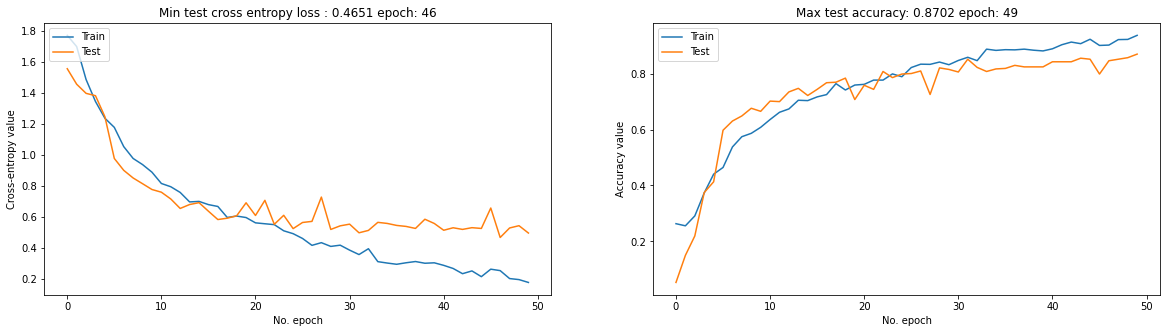

In [207]:
history_vis(history)

In [208]:
pred = model.predict_classes(X_test)
print(classification_report(y_test.values.argmax(axis=1), pred, target_names=classes))

                   precision    recall  f1-score   support

          healthy       0.80      0.92      0.86       148
multiple_diseases       0.45      0.59      0.51        29
             rust       0.98      0.95      0.96       185
             scab       0.91      0.80      0.85       185

         accuracy                           0.87       547
        macro avg       0.79      0.81      0.80       547
     weighted avg       0.88      0.87      0.87       547



# Conclusions

With small dropout values, there is the effect of overfitting. With the growth of the dropout, overfitting decreases, but with a large dropout the model becomes underfitting. 

The best model:


> CNN + dropout 0.7 + balanced class weights = 0.87-89 accuracy on testing dataset

Good idea: data augmentation for class multiple_diseases. F1 score for class multiple_diseases increased from 0.2-0.29 to 0.45-0.53, but total accuracy of model decreased
